<a href="https://colab.research.google.com/github/electropavuk/crypto_trader/blob/master/ipynb/TRIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from itertools import product

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

np.set_printoptions(edgeitems=10, linewidth=200)
pd.options.mode.chained_assignment = None 

google_drive_dir = '/content/drive/MyDrive/Colab Notebooks/crypto_trader/'
data_dir = google_drive_dir + 'data/'

In [2]:
def load_history(filename):
    return pd.read_csv(data_dir + filename)

history = load_history('1h.csv')

In [3]:
def prepare_data(df, period, signal_period='auto'):
    signal_period = period if signal_period == 'auto' else signal_period
    df = df[['Close']]

    close = df['Close']

    ema = lambda x: x.ewm(span=period).mean()
    tma = ema(ema(ema(close)))

    prev = tma.shift(1)
    
    df['trix'] = 100 * 100 * (tma - prev) / prev
    df['signal line'] = df['trix'].rolling(signal_period).mean()

    df = df.dropna()
    
    return df

In [4]:
def simulate(model, data, n, money=100, commision=0.00075):

    trades = []
    init_money = balance = money
    clean = 1 - commision
    quantity = 0

    for t in range(-n, -1):
        action = model(data, t)
        price = data['Close'].iloc[t]
        if action == 'buy' and balance > 0:
            buy_price = price
            quantity = clean * balance / price
            balance = 0
            trades.append(('buy', t, price, balance))
        elif action == 'sell' and quantity > 0:
            balance = clean * quantity * price
            trades.append(('sell', t, price, balance))
            quantity = 0
    
    if quantity > 0:
        balance += quantity * buy_price
        trades.pop()
    
    profit = (balance - init_money) / init_money
    return trades, profit

In [5]:
def config_plot(plt):
    plt.figure(figsize = (30, 5))
    plt.margins(0, .1)
    plt.grid(True)

def show_graph(data, trades):
    xsell, ysell, xbuy, ybuy = [], [], [], []
    for action, t, price, _ in trades:
        if action == 'buy':
            xbuy.append(t)
            ybuy.append(price)
        if action == 'sell':
            xsell.append(t)
            ysell.append(price)

    config_plot(plt)

    x = range(-n, 0)

    # Price and trades
    plt.title('{} trades made'.format(len(trades)))
    plt.plot(x, data['Close'].iloc[-n:], label='Closing price', c='black')

    plt.scatter(xbuy, ybuy, label='Buy', c='blue')
    plt.scatter(xsell, ysell, label='Sell', c='red')
    
    plt.legend()


def show_trix(data):
    config_plot(plt)
    plt.title('Trix')
    plt.plot(range(-n, 0), data['trix'], color='blue', label='trix')
    plt.plot(range(-n, 0), data['signal line'], color='red', linestyle=':', label='signal line')
    plt.legend()


def show_profit(data, trades):
    config_plot(plt)
    xprofit, yprofit = [], []
    balance = init_money = money
    for action, t, price, balance in trades:
        if balance > 0:
            xprofit.append(t)
            yprofit.append(100 * (balance - init_money) / init_money)


    plt.title('Profit')
    plt.plot(xprofit, yprofit, label='Profit', c='black', linestyle=':')
    plt.legend()

In [6]:
# TRIX and signal line (trix ma) crossover
class TRIXCrossover:
    def __init__(self, period=24, patience=1):
        self.period = period
        self.patience = patience

    def __call__(self, data, t):
        trix = data['trix'].iloc[t-self.patience: t+1].values
        signal = data['signal line'].iloc[t-self.patience: t+1].values
        diff = trix > signal
        # print(diff)
        # raise SystemExit
        if not diff[0] and all(diff[1:]):
            return 'buy'
        elif diff[0] and not any(diff[1:]):
            return 'sell'
        else:
            return 'wait'

# buy when dirction changes upward
# sell when direction changes downward
class TRIXDirection:
    def __init__(self, period=24, patience=1):
        self.period = period
        self.patience = patience

    def __call__(self, data, t):
        trix = data['trix'].iloc[t-self.patience-1: t+1]
        diff = (trix > trix.shift(1)).iloc[1:].values
        if not diff.size:
            return 'wait'
        if  not diff[0] and all(diff[1:]):
            return 'buy'
        elif diff[0] and not any(diff[1:]):
            return 'sell'
        else:
            return 'wait'

# buys and sells when eather TRIXCrossover class or TRIXDirection sends signal
class TRIXDirectionAndCrossover:
    def __init__(self, period=24, patience=1):
        self.direction = TRIXDirection(period, patience)
        self.crossover = TRIXCrossover(period, patience)
    
    def __call__(self, data, t):
        direction_signal = self.direction(data, t)
        crossover_signal = self.crossover(data, t)
        if direction_signal != 'wait':
            return direction_signal
        elif crossover_signal != 'wait':
            return crossover_signal
        else:
            return 'wait'

In [7]:
def search_parameters(model_class, *args):
    params = list(product(*args))
    profits = []
    for i, (period, patience) in enumerate(params):
        data = prepare_data(history, period)[-n:]
        model = model_class(period, patience)
        trades, profit = simulate(model, data, n, money=money, commision=0.00075)
        print('iter [ {:>3} / {:>3} ] params {} : profit = {:.1f} %'.format(i + 1, len(params), (period, patience), profit * 100))
        profits.append((profit, (period, patience)))

    profit, (period, patience) = max(profits)
    print('BEST')
    print('params {} : profit = {:.1f} %'.format((period, patience), profit * 100))
    return period, patience











MODEL [ TRIXCrossover ]
profit 268.19172675163065%


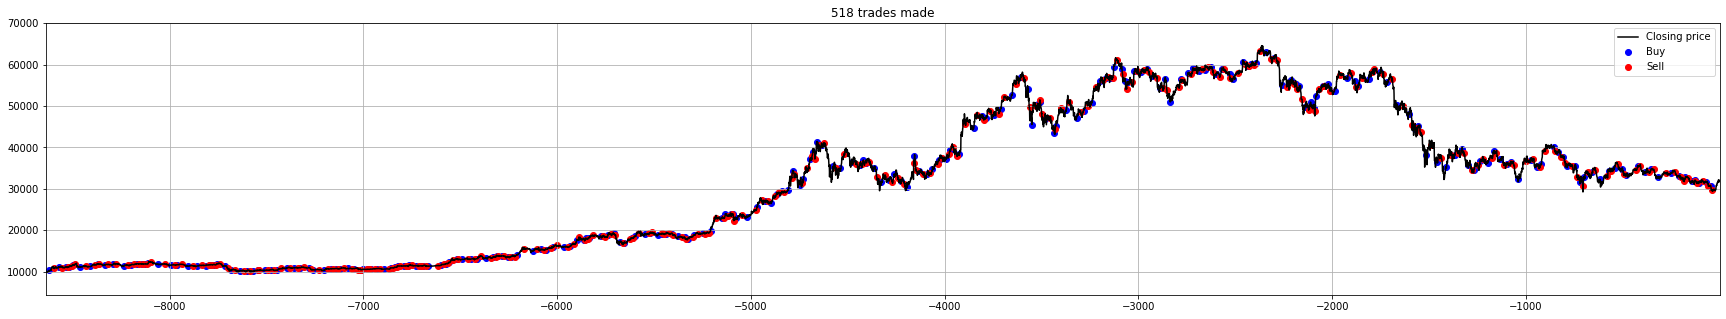

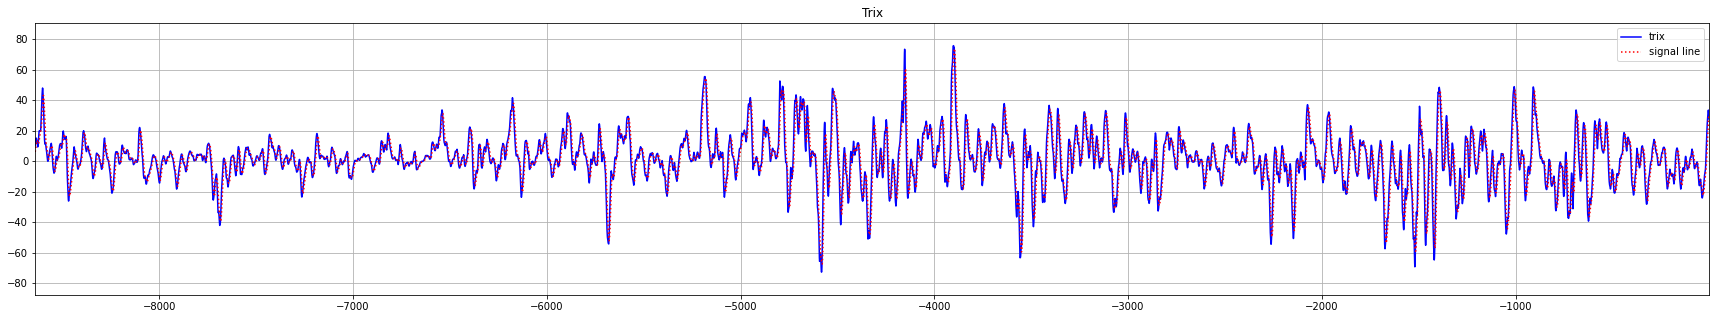

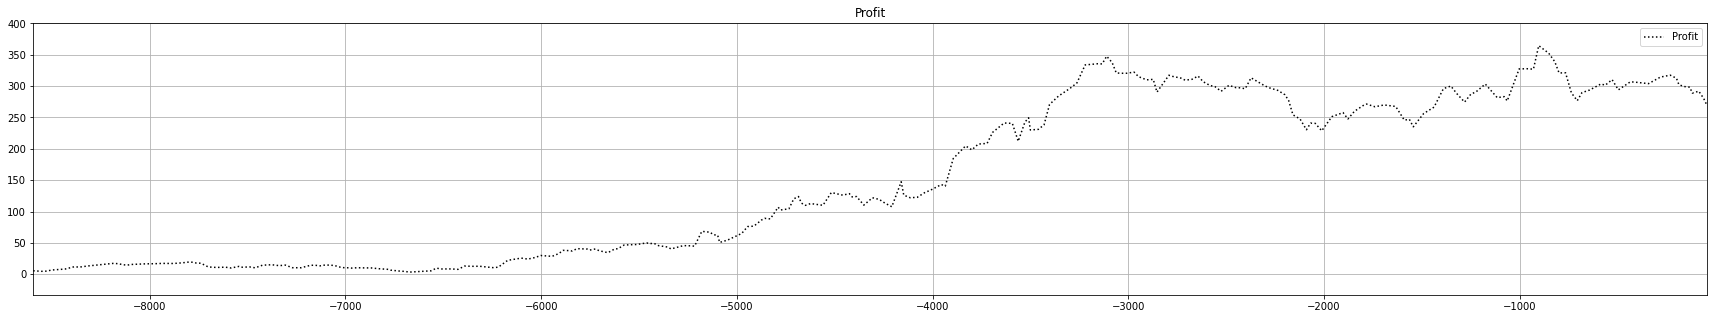











MODEL [ TRIXDirection ]
profit 251.17381310612944%


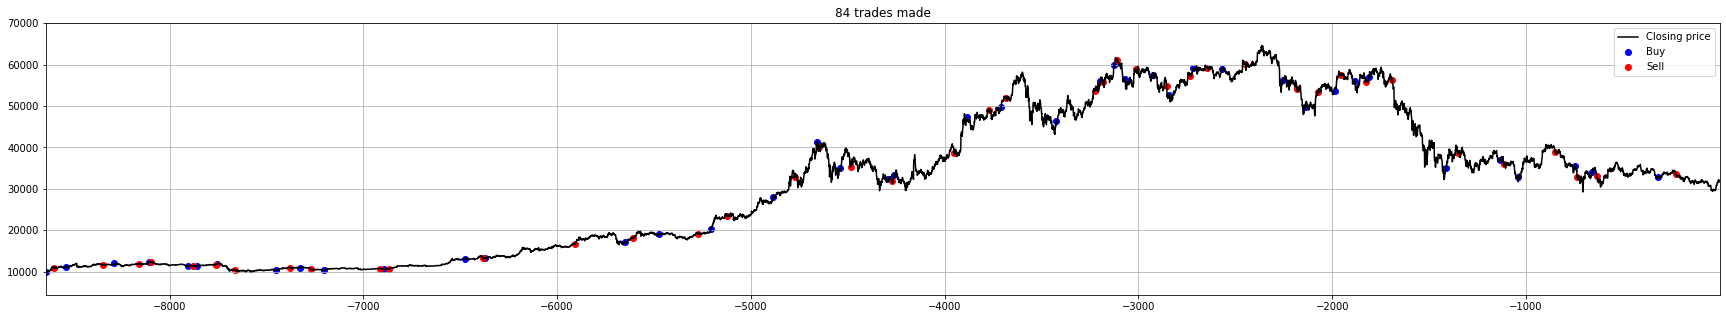

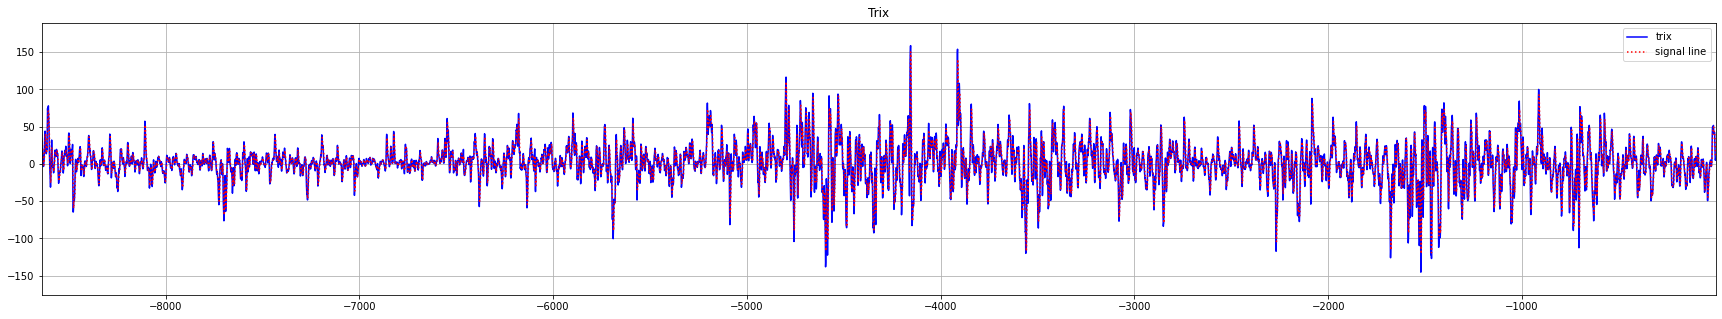

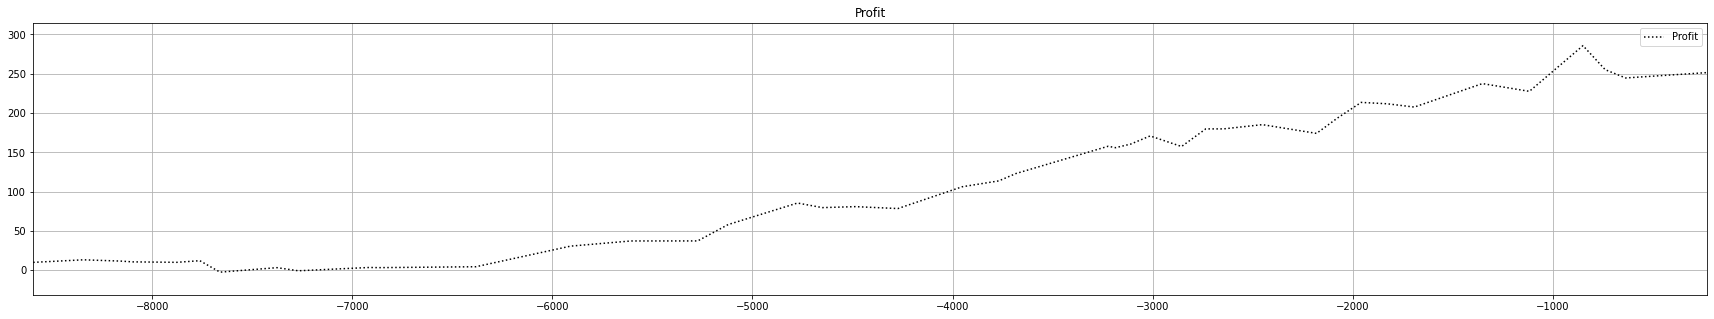











MODEL [ TRIXDirectionAndCrossover ]
profit 294.90393039182123%


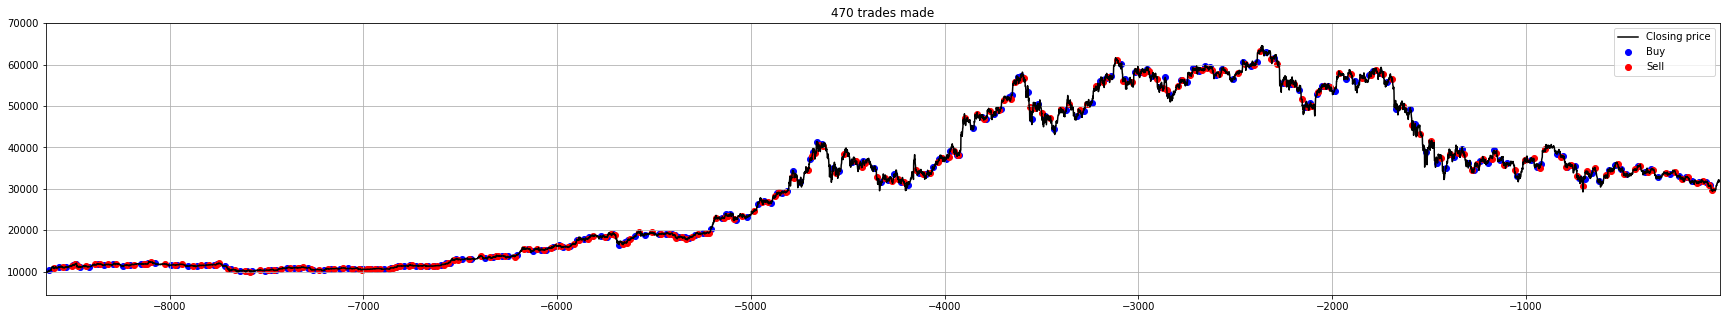

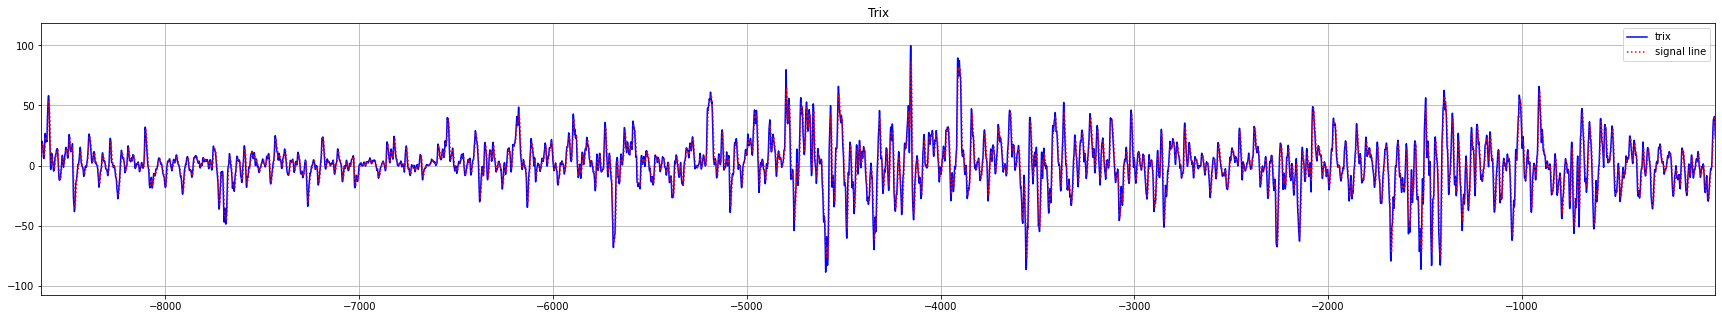

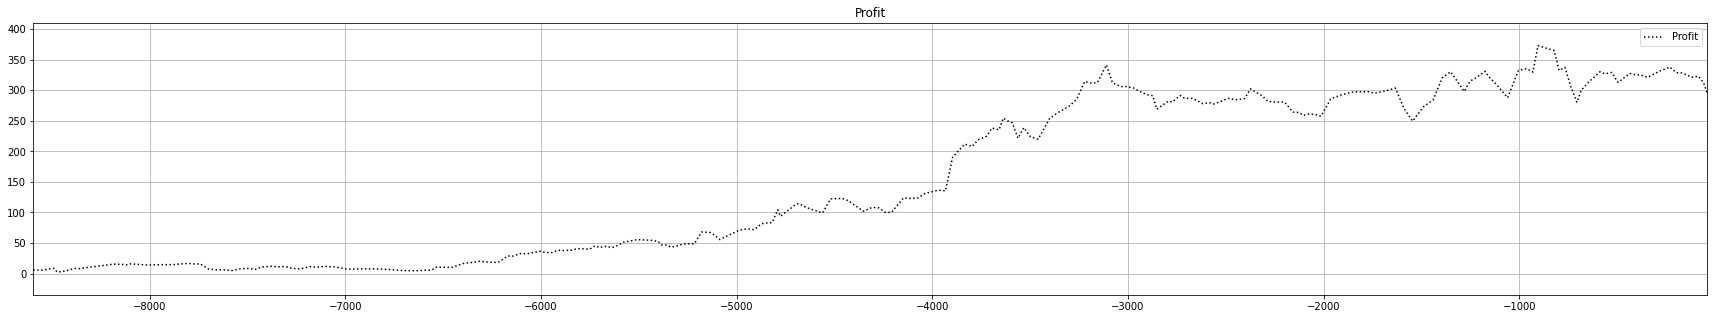

In [8]:
history = load_history('1h.csv')
money = 100
n = 24 * 360


# # trained on 1h, 360 days

# model = TRIXCrossover
# period, patience = 10, 3 # profit = 268 %
# period, patience = 7, 7 # profit = 244 %

# model = TRIXDirection
# period, patience = 4, 9 # profit = 251 %
# period, patience = 10, 5 # profit = 244 %

# model = TRIXDirectionAndCrossover
# period, patience = 7, 7 # profit = 294 %
# period, patience = 10, 5 # profit = 270 %


# period, patience = search_parameters(model, range(4, 40, 3), range(3, 10, 2))

for model, params in zip([TRIXCrossover, TRIXDirection, TRIXDirectionAndCrossover],
                         [(10, 3), (4, 9), (7, 7)]):
    print('\n'*10 + f'MODEL [ {model.__name__} ]')
    period, patience = params
    data = prepare_data(history, period)[-n:]
    model = model(period, patience)
    trades, profit = simulate(model, data, n)

    print(f'profit {100*profit}%')
    show_graph(data, trades)
    show_trix(data)
    show_profit(data, trades)
    plt.show()